# MVP da Pós-graduação em Ciência de Dados e Analytics - Sprint Engenharia de Dados
## Fernanda Pires Valente 

### Neste Noteboobk iremos analisar as tabelas finais para responder as perguntas feitas no início do projeto

### Análise dos dados


Vamos primeiro relembrar quais as perguntas que queremos responder: 

*   Existe alguma relação entre felicidade da população e expectativa de vida?
*   A felicidade da população tem aumentado ou diminuído? Depende do país?
*   A expectativa de vida tem aumentado linearmente durante os anos?
*   A expectativa de vida muda dependendo do país?
*   A expectativa de vida de países desenvolvido é diferente da de subdesenvolvido? E com relação aos continentes, tem diferença?
*   A expectativa de vida está relacionada com o tamanho da população? E com a escolariedade das pessoas?





##### 1. Existe alguma relação entre felicidade da população e expectativa de vida?

Vamos aqui juntar a expectativa de vida da tabela tb_life_expectancy_gold e a pontuação de felicidade da tabela tb_world_happiness_report_silver. </br> 

Depois vamos gerar um gráfico de dispersão, onde o eixo x representa a pontuação de felicidade (happiness_score) e o eixo y representa a expectativa de vida (life_expectancy_world_bank)

In [0]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

# Executar a query SQL e armazenar o resultado em um DataFrame
query = """
with 
tb_leg as (select year, country, life_expectancy_world_bank from `tb_life_expectancy_gold`)
,tb_whrs as (select year, country, happiness_score from `tb_world_happiness_report_silver`)
select 
  tb_whrs.* 
  ,tb_leg.life_expectancy_world_bank
from tb_whrs 
left join tb_leg 
  on tb_leg.year = tb_whrs.year
  and tb_leg.country = tb_whrs.country"""

df_result = spark.sql(query)


In [0]:
# Converter o DataFrame PySpark para um DataFrame Pandas
pdf_result = df_result.toPandas()

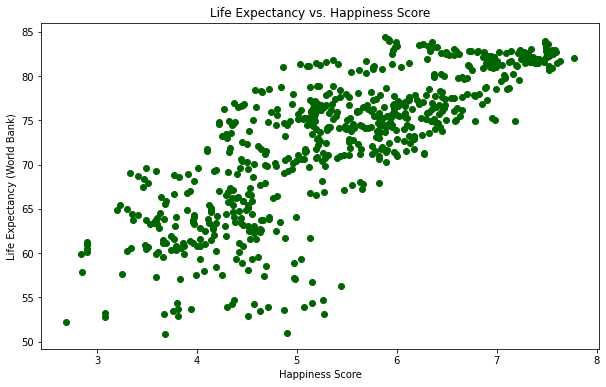

In [0]:
# Configurar o gráfico
plt.figure(figsize=(10, 6))

# Plotar os dados
plt.scatter(pdf_result['happiness_score'], pdf_result['life_expectancy_world_bank'], color='darkgreen')

# Adicionar título e legendas
plt.title('Life Expectancy vs. Happiness Score')
plt.xlabel('Happiness Score')
plt.ylabel('Life Expectancy (World Bank)')

# Mostrar o gráfico
plt.show()

Olhando o gráfico podemos perceber que conforme a expectativa de vida aumenta a pontuação de felicidade também parece aumentar.

In [0]:
# Calculando a correlação entre happiness_score e life_expectancy_world_bank usando PySpark
correlation = df_result.stat.corr("happiness_score", "life_expectancy_world_bank")
print(f"Correlação entre Happiness Score e Life Expectancy (PySpark): {correlation}")

Correlação entre Happiness Score e Life Expectancy (PySpark): 0.29813418788790147


De fato a relação entre as duas variáveis é positiva, mas elas não possuem uma correlação alta

##### 2. A felicidade da população tem aumentado ou diminuído? Depende do país?

Vamos tomar a liberdade de calcular a média das pontuações de felicidade de cada ano para verficar se essa média aumentou, sabemos que cada país tem população de tamanho diferente e que talvez uma média ponderada daria uma visão mais realista. Como não temos o tamanho da população dos países em cada ano, iremos seguir com uma média simples

In [0]:

%sql

select 
year,
min(happiness_score) pontuacao_min_de_felicidade,
mean(happiness_score) pontuacao_media_de_felicidade,
max(happiness_score) pontuacao_max_de_felicidade
from `tb_world_happiness_report_silver`
group by 1 order by 1 


year,pontuacao_min_de_felicidade,pontuacao_media_de_felicidade,pontuacao_max_de_felicidade
2015,2.839,5.3757341772151905,7.587
2016,2.905,5.382184713375795,7.526
2017,2.69300007820129,5.354019355773926,7.53700017929077
2018,2.905,5.375916666666668,7.632
2019,2.853,5.407096153846153,7.769


Parece que não houve muita mudança durante os anos com relação a pontuação de felicidade. Vale mencionar que a maior nota aumentou um pouco nos últimos 2 anos dos nossos dados. Vamos também olhar o número médio de forma visual nas próximas linhas 

In [0]:
# Executar a query SQL e armazenar o resultado em um DataFrame
query = """select year, country, happiness_score
from `tb_world_happiness_report_silver` where happiness_score is not null"""

df_result = spark.sql(query)


In [0]:
from pyspark.sql.functions import avg, collect_list, lag
from pyspark.sql import Window

# Definir uma janela para calcular a diferença entre anos consecutivos
window_spec = Window.partitionBy('country').orderBy('year')


In [0]:

# Calcular a mudança na pontuação de felicidade de um ano para outro
# Aqui estamos fazendo dessa forma pois temos países que não aparecem nas pesquisas dos 5 anos
df_trend = df_result.withColumn('prev_avg_happiness_score', lag('happiness_score').over(window_spec))
df_trend = df_trend.withColumn('happiness_diff', df_trend['happiness_score'] - df_trend['prev_avg_happiness_score'])
pdf_trend = df_trend.toPandas()

In [0]:
# Calcular a média global da pontuação de felicidade por ano
df_global_trend = df_result.groupBy('year').agg(avg('happiness_score').alias('global_avg_happiness'))


Vamos ver visualmente como está a média de felicidade global dos anos de 2015 à 2019

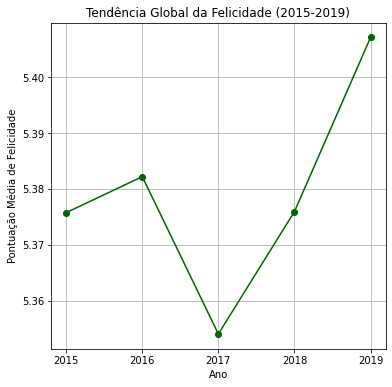

In [0]:
# Converter o DataFrame para Pandas
pdf_global_trend = df_global_trend.toPandas()

# Plotar a tendência global
plt.figure(figsize=(6, 6))
pdf_global_trend = pdf_global_trend.sort_values(by='year')
plt.plot(pdf_global_trend['year'], pdf_global_trend['global_avg_happiness'], marker='o', color='darkgreen')
plt.title('Tendência Global da Felicidade (2015-2019)')
plt.xticks(pdf_global_trend['year'])
plt.xlabel('Ano')
plt.ylabel('Pontuação Média de Felicidade')
plt.grid(True)
plt.show()

Vamos escolher alguns países para analises a evolução

In [0]:

%sql
/* Vendo os dois países com as maiores pontuações */
select 
country,
max(happiness_score) pontuacao_min_de_felicidade
from `tb_world_happiness_report_silver`
group by 1 order by 2 desc limit 2


country,pontuacao_min_de_felicidade
Finland,7.769
Denmark,7.6


In [0]:

%sql
/* Vendo os dois países com as menores pontuações */
select 
country,
min(happiness_score) pontuacao_min_de_felicidade
from `tb_world_happiness_report_silver`
group by 1 order by 2 asc limit 2

country,pontuacao_min_de_felicidade
Central African Republic,2.69300007820129
Togo,2.839


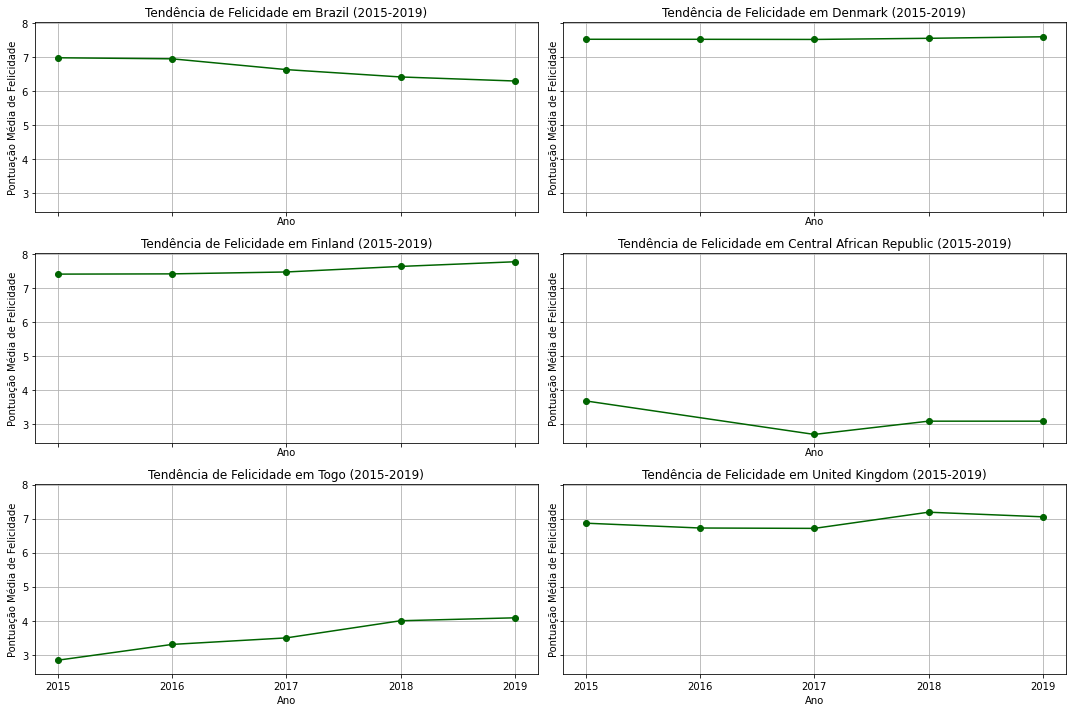

In [0]:
# Lista de 6 países específicos
countries = ['Brazil', 'Denmark', 'Finland', 'Central African Republic', 'Togo', 'United Kingdom']

# Criar subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharex=True, sharey=True)

# Iterar sobre os países e plotar cada um em um subplot
for i, country in enumerate(countries):
    row, col = divmod(i, 2)
    country_data = pdf_trend[pdf_trend['country'] == country]
    axes[row, col].plot(country_data['year'], country_data['happiness_score'], marker='o', color='darkgreen')
    axes[row, col].set_title(f'Tendência de Felicidade em {country} (2015-2019)')
    axes[row, col].set_xlabel('Ano')
    axes[row, col].set_ylabel('Pontuação Média de Felicidade')
    axes[row, col].grid(True)
    axes[row, col].set_xticks(pdf_trend['year'].unique()) 

# Ajustar layout
plt.tight_layout()

# Mostrar o gráfico
plt.show()

Podemos perceber que a pontuação de felicidade do Brasil tem caido com os anos, enquanto que a pontação de felicidade do Togo e da Finland tem aumentado. Para o Reino Unido, a felicidade variou um pouco porém a pontuação de 2019 está bem próxima da pontuação de 2015. 

A Dinamarca é bem estável, com uma pontuação bem alta em todos os anos. Na célula abaixo podemos ver que a Dinamarca está sempre nos top 3 países mais felizes em todos os anos.

In [0]:

%sql
/* Vendo os top 3 países de cada ano */
select 
year,
overall_rank,
country,
happiness_score
from `tb_world_happiness_report_silver`
where overall_rank in (1,2,3)
order by 1,2

year,overall_rank,country,happiness_score
2015,1,Switzerland,7.587
2015,2,Iceland,7.561
2015,3,Denmark,7.527
2016,1,Denmark,7.526
2016,2,Switzerland,7.509
2016,3,Iceland,7.501
2017,1,Norway,7.53700017929077
2017,2,Denmark,7.52199983596802
2017,3,Iceland,7.50400018692017
2018,1,Finland,7.632


##### 3. A expectativa de vida tem aumentado linearmente durante os anos?


In [0]:
# Executar a query SQL e armazenar o resultado em um DataFrame
query = """select year,  mean(life_expectancy_world_bank) life_expectancy 
from `tb_life_expectancy_gold`
group by 1 order by 1"""

df_result = spark.sql(query)


In [0]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

# Montar o vetor de características
assembler = VectorAssembler(inputCols=['year'], outputCol='features')
df_features = assembler.transform(df_result)

# Ajustar o modelo de regressão linear
lr = LinearRegression(featuresCol='features', labelCol='life_expectancy')
lr_model = lr.fit(df_features)

# Obter o resumo do modelo
training_summary = lr_model.summary

# Mostrar os coeficientes e o intercepto
print(f"Coeficiente: {lr_model.coefficients}")
print(f"Intercepto: {lr_model.intercept}")

# Mostrar o coeficiente de determinação R^2
print(f"R^2: {training_summary.r2}")

Coeficiente: [0.34859669673747506]
Intercepto: -630.9295113144893
R^2: 0.995073833161259


Como obtivemos um R² próximo de 1, isso significa que no nosso modelo limear explica bem a variação dos dados. Ou seja, estamos tendo sim um aumento linear da expectativa de vida durante o passar dos anos.

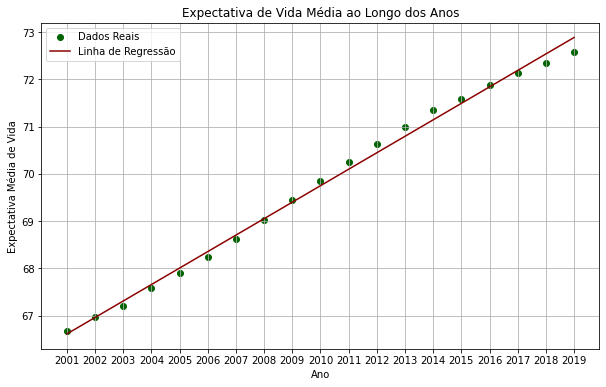

In [0]:
import pandas as pd

# Converter para DataFrame Pandas
pdf_result= df_result.toPandas()

# Prever valores usando o modelo de regressão
pdf_result['predicted_life_expectancy'] = lr_model.transform(df_features).select('prediction').toPandas()

# Plotar os dados reais e a linha de regressão
plt.figure(figsize=(10, 6))
plt.scatter(pdf_result['year'], pdf_result['life_expectancy'], label='Dados Reais', color='darkgreen')
plt.plot(pdf_result['year'], pdf_result['predicted_life_expectancy'], color='darkred', label='Linha de Regressão')
plt.xlabel('Ano')
plt.ylabel('Expectativa Média de Vida')
plt.title('Expectativa de Vida Média ao Longo dos Anos')
plt.xticks(pdf_result['year'])
plt.legend()
plt.grid(True)
plt.show()

##### 4. A expectativa de vida muda dependendo do país?


Vamos olhar para os mesmo 5 países + Argentina para ver graficamente se a expectativa de vida muda conforme o país

In [0]:
# Executar a query SQL e armazenar o resultado em um DataFrame
query = """select year, country,  mean(life_expectancy_world_bank) life_expectancy 
from `tb_life_expectancy_gold`
where country in ('Brazil', 'Denmark', 'Finland', 'Central African Republic', 'Togo', 'United Kingdom', 'Argentina')
group by 1,2 """

df_result = spark.sql(query)
pdf_result = df_result.toPandas()

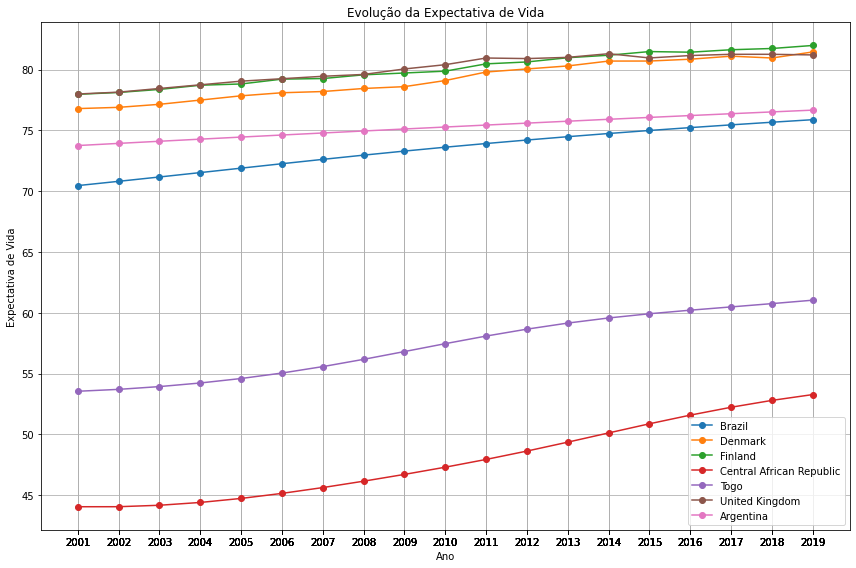

In [0]:
from pyspark.sql.functions import col


# filtrando países e ordenando o df
paises = ['Brazil', 'Denmark', 'Finland', 'Central African Republic', 'Togo', 'United Kingdom', 'Argentina']
pdf_result = pdf_result.sort_values(by='year')
# Plotando o gráfico
plt.figure(figsize=(12, 8))

for pais in paises:
    dados_pais = pdf_result[pdf_result['country'] == pais]
    plt.plot(dados_pais['year'], dados_pais['life_expectancy'], marker='o', label=pais)

plt.title('Evolução da Expectativa de Vida')
plt.xlabel('Ano')
plt.ylabel('Expectativa de Vida')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(pdf_result['year'])

# Exibindo o gráfico
plt.show()


No geral vemos nos 6 países seleiconados um aumento na expectativa de vida conforme os anos, o maior aumento é de Central African Republic. Por mais que a métrica aumente, ainda é claro que a expectativa de vida de cada país pode ser bem diferente dependendo dos países que comparamos. </br>

No futuro podemos aplicar a ANOVA para entender se existe uma diferença significativa entre os países. 

##### 5. A expectativa de vida de países desenvolvido é diferente da de subdesenvolvido? E com relação aos continentes, tem diferença?


Olhando por grupo de renda:

In [0]:
# Executar a query SQL e armazenar o resultado em um DataFrame
query = """select year, income_group ,  mean(life_expectancy_world_bank) life_expectancy 
from `tb_life_expectancy_gold` t1
group by 1,2"""

df_result = spark.sql(query)
pdf_result = df_result.toPandas()

In [0]:
# Executar a query SQL e armazenar o resultado em um DataFrame
query = """select distinct income_group from `tb_life_expectancy_gold`"""

df_income_group = spark.sql(query)

# Coletando os dados do DataFrame em uma lista
income_group_list = df_income_group.select("income_group").rdd.flatMap(lambda x: x).collect()

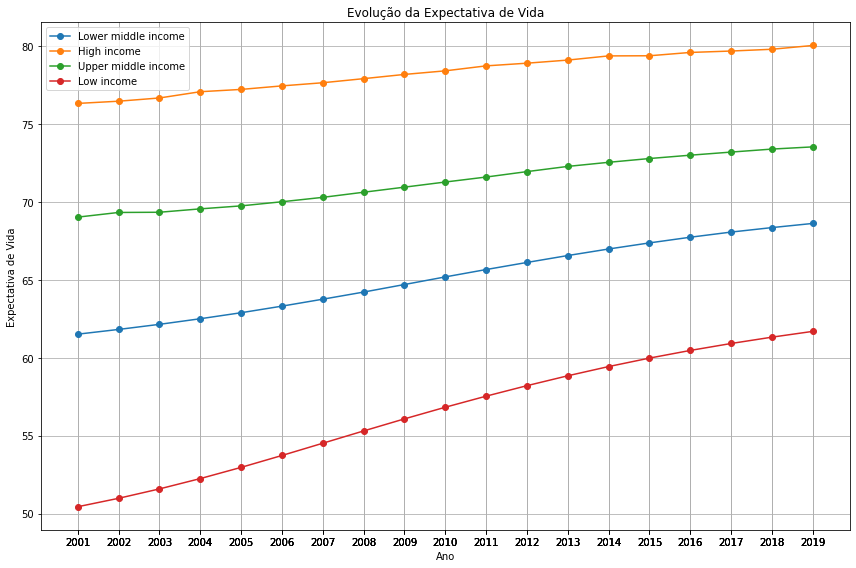

In [0]:

pdf_result = pdf_result.sort_values(by='year')
# Plotando o gráfico
plt.figure(figsize=(12, 8))

for grupo in income_group_list:
    dados_grupo = pdf_result[pdf_result['income_group'] == grupo]
    plt.plot(dados_grupo['year'], dados_grupo['life_expectancy'], marker='o', label=grupo)

plt.title('Evolução da Expectativa de Vida')
plt.xlabel('Ano')
plt.ylabel('Expectativa de Vida')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(pdf_result['year'])

# Exibindo o gráfico
plt.show()


Sim, a expectativa de vida é diferente quando olhamos para países com rendas diferentes. Quanto maior a renda maior é a expectativa de vida. Vale ressaltar que a expectativa de vida dos países de baixa renda em 2019 não alcança a expectativa de vida que os países de alta e média alta renda tinham em 2001.

Olhando por região:

In [0]:
# Executar a query SQL e armazenar o resultado em um DataFrame
query = """select year, region_world ,  mean(life_expectancy_world_bank) life_expectancy 
from `tb_life_expectancy_gold` t1
left join `tb_region_gold` t2 on t1.country = t2.country
group by 1,2"""

df_result = spark.sql(query)
pdf_result = df_result.toPandas()

In [0]:
# Executar a query SQL e armazenar o resultado em um DataFrame
query = """select distinct region_world from `tb_region_gold`"""

df_regioes = spark.sql(query)

# Coletando os dados do DataFrame em uma lista
region_world_list = df_regioes.select("region_world").rdd.flatMap(lambda x: x).collect()

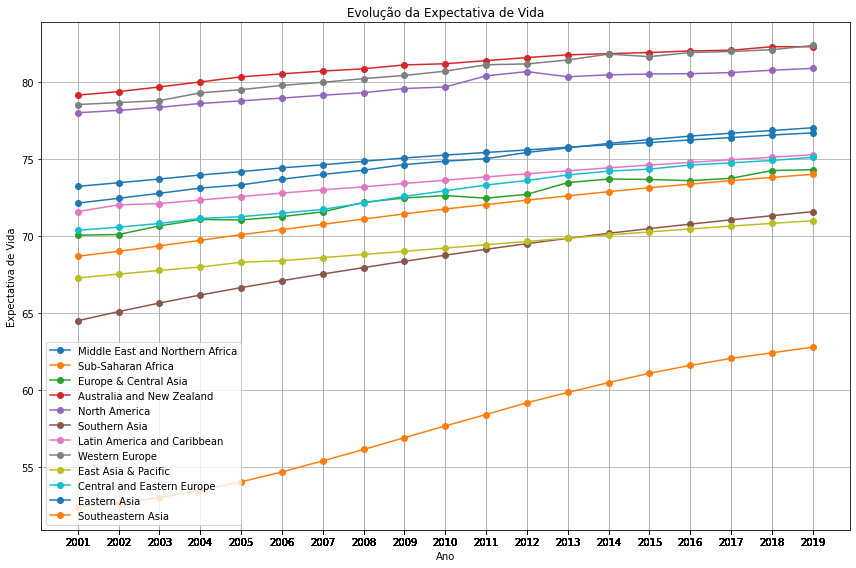

In [0]:

pdf_result = pdf_result.sort_values(by='year')
# Plotando o gráfico
plt.figure(figsize=(12, 8))

for regiao in region_world_list:
    dados_regiao = pdf_result[pdf_result['region_world'] == regiao]
    plt.plot(dados_regiao['year'], dados_regiao['life_expectancy'], marker='o', label=regiao)

plt.title('Evolução da Expectativa de Vida')
plt.xlabel('Ano')
plt.ylabel('Expectativa de Vida')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(pdf_result['year'])

# Exibindo o gráfico
plt.show()


A expectativa de vida também é diferente dependendo das regiões que comparamos. 
</br>

Por exemplo, a expectativa da Austrália e Nova Zelância é mais alta que a expectativa do Sul da Ásia (Southern Asia), porém, por um outro lado, ela é bem parecida com a expectativa de vida da América do Norte (North America) e Europa Ocidental (Western Europe).

##### 6. A expectativa de vida está relacionada com o tamanho da população? E com a escolariedade das pessoas?

Não temos essas informações nas nossas bases, porém ainda considero uma questão interessante para avaliar no futuro

#### Perguntas extras 

Percebi enquanto analisava os dados que com as informações das tabelas que temos podemos responder a mais perguntas interessantes. Vou deixar aqui algumas delas

1. Será que os países com as maiores pontuações de felicidade são os países com a maior expectativa de vida?

In [0]:

%sql
with  tb_aux as (select year, country, life_expectancy_world_bank, RANK() OVER (PARTITION BY year ORDER BY life_expectancy_world_bank DESC) as rank
          from `tb_life_expectancy_gold` where year >= 2015)
select 
  t1.year,
  t1.country, 
  happiness_score,
  rank as rank_life_expectancy,
  life_expectancy_world_bank
from `tb_world_happiness_report_silver` t1
left join tb_aux t2 on t1.year = t2.year and t1.country = t2.country
where overall_rank in (1,2,3)
order by 1,3 desc


year,country,happiness_score,rank_life_expectancy,life_expectancy_world_bank
2015,Switzerland,7.587,2,82.89756097560976
2015,Iceland,7.561,6,82.46829268292684
2015,Denmark,7.527,26,80.70243902439024
2016,Denmark,7.526,27,80.85365853658537
2016,Switzerland,7.509,2,83.60243902439025
2016,Iceland,7.501,13,82.2048780487805
2017,Norway,7.53700017929077,7,82.60975609756098
2017,Denmark,7.52199983596802,25,81.10243902439025
2017,Iceland,7.50400018692017,6,82.6609756097561
2018,Finland,7.632,19,81.73414634146343


Podemos ver que nem sempre os países com as maiores pontuações são os países com a maior expectativa de vida, mas que pelo menos eles sempre estão entre os top 50 países com maior expectativa de vida da bases.

2. Será que a expectativa de vida está relacionada com as emissões de CO2?
3. E com relação a porcentagem da população cujo consumo habitual de alimentos é insuficiente para fornecer a dieta?
4. Será que o ínidce de desemprego está diretamente relacionado com a felicidade?
5. Quando o volume das despesas gerais do governo com a educação aumentam será que e expectativa de vida aumenta nos anos seguintes?
6. Será que a expectativa de vida aumenta quando a generosidade que contribuiu para o cálculo da Pontuação de Felicidade aumenta?
7. Será que conseguimos criar uma regressão para prever qual a pontuação de felicidade de cada país para os próximos anos? E a expectativa de vida?
8. Como é a pontuação de felicidade por região? Tem diferenças grandes por regiões?

### Conclusão:



O principal objetivo deste projeto foi aplicar o conhecimento adquirido na Sprint de Engenharia de Dados da Pós-graduação em Ciência de Dados e Analytics.
</br>

Utilizamos o Databricks Community como ferramenta para ingestão, tratamento dos dados e criação de tabelas em diferentes camadas: a camada bronze com dados brutos, a camada silver com dados tratados, e a camada gold com dados após aplicação de regras de negócio.
</br>

Para as análises de dados, utilizamos tanto SQL quanto PySpark, e buscamos responder todas as perguntas que motivaram o projeto.
</br>

A análise realizada nos trouxe alguns insights importantes sobre a relação entre a felicidade da população e a expectativa de vida, bem como suas variações ao longo dos anos e entre diferentes países.
</br>

* A relação entre felicidade e expectativa de vida é positiva, mas a correlação não é forte. Ao analisar a média global das pontuações de felicidade, observamos que não houve mudanças significativas ao longo dos anos. No entanto, a felicidade variou de maneira diferente entre os países.
</br>

* A expectativa de vida mostrou um aumento linear ao longo dos anos, como evidenciado pelo alto R² do modelo linear. Apesar do aumento geral, a expectativa de vida varia significativamente entre os países. Países com maior renda tendem a ter maior expectativa de vida, e essa diferença é evidente quando comparamos regiões como a Austrália e Nova Zelândia com o Sul da Ásia.
</br>

* Em resumo, tanto a felicidade quanto a expectativa de vida variam de maneira complexa e são influenciadas por vários fatores, incluindo renda e região geográfica. 
</br>

Um próximo passo para esse estudo seria incluir dados sobre tamanho da população e escolaridade para obter uma compreensão mais abrangente dessas relações e responder as perguntas extras buscando entender cada vez mais os dados. 





Notas extras:

Durante esse projeto, esbarrei em algumas dificuldades que vale a pena mencionar.

Percebi que criei uma tabela desnecessariamente, a tb_year_silver. Ela não foi necessária em nenhuma análise. Talvez se os dados estivessem em dias ou semetres fizesse sentido tem uma tabela com o ano para fazer o agrupamento dos dados no ano.

Os dados fontes utilizados nesse projeto estavam bem documentados no Kaggle, a explicação de cada campo estava completa, porém senti falta do intervalo de variação dos campos, principalmente os campos numéricos. 

Utilizar o Databricks Community tem uma peculiariedade que o cluster é finalizado com 30 minutos, isso fez com que toda vez que eu fosse trabalhar no projeto era necessário recriar todas as tabelas do banco de dados.

